#  MLP Variational Autoencoder for MNIST dataset
# + 
# Static plots for training and latent interpolation
implement probability and sampling with torch.distribution package, modified from [this link](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed)

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.distributions as torchD

import torch, seaborn as sns
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from utils import *

In [2]:
# # set seed for reproducibility
# seed = 24
# torch.manual_seed(seed)
# np.random.seed(seed)

## Load Dataset

In [3]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [4]:
batch_size = 128

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # ToTensor() will normalize data to (0,1)

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Variational Autoencoder
A MLP variational autoencoder is used. <br/>
The mean and s.d. of the approximate posterior are outputs of the encoding MLP. See more details at [VAE paper](https://arxiv.org/pdf/1312.6114.pdf)

In [ ]:
class MLP_V_Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(MLP_V_Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=np.prod(kwargs["input_shape"]), out_features=kwargs["enc_dim"]),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        enc_out = self.model(x)
        return enc_out

class MLP_V_Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(MLP_V_Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=kwargs["latent_dim"], out_features=kwargs["enc_dim"]),
            nn.ReLU(),
            nn.Linear(in_features=kwargs["enc_dim"], out_features=np.prod(kwargs["input_shape"])),
            nn.Sigmoid() # push the pixels in range (0,1)   
        )
        self.output_shape = kwargs["input_shape"]
    
    def forward(self, latent):
        x_bar = self.model(latent)
        x_bar = x_bar.view([-1]+ self.output_shape)      
        return x_bar
    
class MLP_VAE(nn.Module):
    """
    TODO: check whether to use sum or mean for the probability part
    """
    def __init__(self, **kwargs):
        # kwargs["input_shape"] = [1,28,28]
        # kwargs["latent_dim"] = 4
        super(MLP_VAE, self).__init__()
        self.encoder = MLP_V_Encoder(**kwargs)
        self.decoder = MLP_V_Decoder(**kwargs)
        
        # distribution layers
        self.enc_dim = kwargs["enc_dim"]
        self.latent_dim = kwargs["latent_dim"]
        self.enc_to_mean = nn.Linear(self.enc_dim, self.latent_dim)
        self.enc_to_logvar = nn.Linear(self.enc_dim, self.latent_dim)
    
    def encode(self, x):
        enc_out = self.encoder(x)
        mean = self.enc_to_mean(enc_out)
        logvar = self.enc_to_logvar(enc_out)
        return mean, logvar
    
    def decode(self, latent):
        return self.decoder(latent)
    
    def pxz_likelihood(self, x, x_bar, scale=1., dist_type="Gaussian"):
        """
        compute the likelihood p(x|z) based on predefined distribution, given a latent vector z
        default scale = 1, can be broadcasted to the shape of x_bar
        """
        if dist_type == "Gaussian":
            dist = torch.distributions.Normal(loc=x_bar, scale=scale)
        else:
            raise NotImplementedError("unknown distribution for p(x|z) {}".format(dist_type))
        
        log_pxz = dist.log_prob(x)
        return log_pxz.sum() # log_pxz.sum((1,2,3))
    
    def kl_divergence(self, mean, logvar):
        """
        Monte Carlo way to solve KL divergence
        """
        pz = torchD.Normal(torch.zeros_like(mean), scale=1)
        std = torch.exp(0.5*logvar)
        qzx = torchD.Normal(loc=mean, scale=std)
        
        z = qzx.rsample() # reparameterized sampling, shape [32,2]
        
        # clamp the log prob to avoid -inf
        qzx_lp = qzx.log_prob(z).clamp(min=-1e10, max=0.)
        pz_lp = pz.log_prob(z).clamp(min=-1e10, max=0.)

        kl = qzx_lp - pz_lp
        if torch.isnan(qzx_lp).any():
            raise ValueError("nan in qzx_lp")
        if torch.isnan(pz_lp).any():
            raise ValueError("nan in pz_lp")
        if torch.isnan(kl.mean()).any():
            raise ValueError("nan in kl")
        return kl.sum()
    
    def reparameterize(self, mean, logvar):
        # assume Gaussian for p(epsilon)
        sd = torch.exp(0.5*logvar)
        # use randn_like to sample N(0,1) of the same size as std/mean
        # default only sample once, otherwise should try sample multiple times take mean
        eps = torch.randn_like(sd) 
        return mean + sd * eps
    
    def sample_latent_embedding(self, mean, logvar, method="reparameterize"):
        """
        Write a sampling function to make function name consistent
        """
        if method=="reparameterize":
            return self.reparameterize(mean, logvar)
        else:
            raise NotImplementedError("Unrecognized method for sampling latent embedding {}".format(method))
    
    def forward(self, x, if_plot_pq=False):
        latent_mean, latent_logvar = self.encode(x)
        latent = self.reparameterize(latent_mean, latent_logvar)
        x_bar = self.decoder(latent)
        
        if if_plot_pq:
            plot_p_q(latent_mean, latent_logvar)
            
        return latent, x_bar, latent_mean, latent_logvar

## Training process

In [8]:
def train(model, device, train_loader, num_epochs=5, learning_rate=1e-3, use_scheduler=False, w_kl=10, w_r=1):
    recon_loss_fn = nn.BCELoss(reduction="sum")

    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                           # weight_decay=5e-4,
                           )
    if use_scheduler:
        step_size = 5
        gamma = 0.1
        scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=step_size, gamma=gamma)
    
    epoch_train_loss = []
    epoch_train_kl_loss = []
    epoch_train_recon_loss = []
    epoch_sample_img = []
    epoch_sample_reconstruction = []
    epoch_sample_latent = []
    epoch_train_kl_divergence = []
    epoch_train_pxz_likelihood = []
    epoch_train_elbo = []
    
    model.train()
    for epoch in range(num_epochs):
        
        model.train()
        
        train_loss = 0
        train_kl_loss = 0
        train_recon_loss = 0
        train_kl_divergence = 0
        train_pxz_likelihood = 0
        train_elbo = 0
        
        
        for img, label in train_loader:
            optimizer.zero_grad()
            
            img, label = img.to(device), label.to(device)
            
            latent, reconstruction, latent_mean, latent_logvar = model(img)
            kl_loss = -0.5 * torch.sum(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
            kl_divergence = model.kl_divergence(latent_mean, latent_logvar)

            recon_loss = recon_loss_fn(reconstruction, img)
            pxz_likelihood = model.pxz_likelihood(img, reconstruction)
            elbo = pxz_likelihood - kl_divergence # should be maximized
            
            loss = w_kl*kl_loss + w_r*recon_loss
            
            loss.backward()
            train_loss += loss.item()
            train_kl_loss += kl_loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_divergence += kl_divergence.item()
            train_pxz_likelihood += pxz_likelihood.item()
            train_elbo += elbo.item()
            
            optimizer.step()
                     
        
        if use_scheduler:
            scheduler.step()
            
        train_loss = train_loss/len(train_loader)
        train_kl_loss = train_kl_loss/len(train_loader)
        train_recon_loss = train_recon_loss/len(train_loader)
        train_kl_divergence = train_kl_divergence/len(train_loader)
        train_pxz_likelihood = train_pxz_likelihood/len(train_loader)
        train_elbo = train_elbo/len(train_loader)
        
        
        if (epoch<5) or (epoch%5 == 0):
            print("Epoch {}, Loss {:.4f}, kl_loss {:.4f}, recon_loss {:.4f}, kl_divergence {:.4f}".format(epoch+1, float(train_loss), float(train_kl_loss), float(train_recon_loss), float(train_kl_divergence)))
#             plot_latent(label, latent, dtype="tensor", suptitle_app="_train")
#             plot_p_q(latent_mean, latent_logvar, suptitle_app="_train")
            
            if use_scheduler:
                print("current learning rate {}".format(scheduler.get_last_lr()))
            
            # test dataset, plot latent for one batch
            model.eval()
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)
                latent, reconstruction, latent_mean, latent_logvar = model(img)
                plot_latent(label, latent, dtype="tensor", suptitle_app="_test")
                plot_p_q(latent_mean, latent_logvar, suptitle_app="_test")
                break

  
        epoch_train_loss.append(train_loss)
        epoch_train_kl_loss.append(train_kl_loss)
        epoch_train_recon_loss.append(train_recon_loss)
        
        epoch_sample_img.append(img.cpu().detach().numpy())
        epoch_sample_reconstruction.append(reconstruction.cpu().detach().numpy())
        epoch_sample_latent.append(latent.cpu().detach().numpy())
        
        epoch_train_kl_divergence.append(train_kl_divergence)
        epoch_train_pxz_likelihood.append(train_pxz_likelihood)
        epoch_train_elbo.append(train_elbo)
        
        results_dict = {
            "train_loss": np.array(epoch_train_loss),
            "train_kl_loss": np.array(epoch_train_kl_loss),
            "train_recon_loss": np.array(epoch_train_recon_loss),
            "sample_img": np.array(epoch_sample_img),
            "sample_reconstruction": np.array(epoch_sample_reconstruction),
            "sample_latent": np.array(epoch_sample_latent),
            "train_kl_divergence": np.array(epoch_train_kl_divergence),
            "train_pxz_likelihood": np.array(epoch_train_pxz_likelihood),
            "train_elbo": np.array(epoch_train_elbo)
        }
        
    return model, results_dict   

In [9]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = [1, 28, 28]
enc_dim = 400
latent_dim = 2
num_epochs = 50
learning_rate = 1e-3
logDir = "models_and_stats/"
w_r = 1
w_kl = 10
model_name = "MLP_VAE_dist_l2_wkl_{}_wr_{}".format(w_kl, w_r)
model_path = logDir + model_name + ".pt"
dict_name = model_name + '.pkl'

In [10]:
pretrain = True

Epoch 1, Loss 24439.6577, kl_loss 741.7957, recon_loss 23697.8620, kl_divergence 629.5268
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


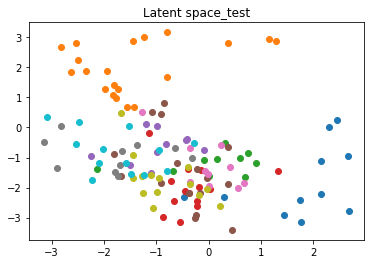

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


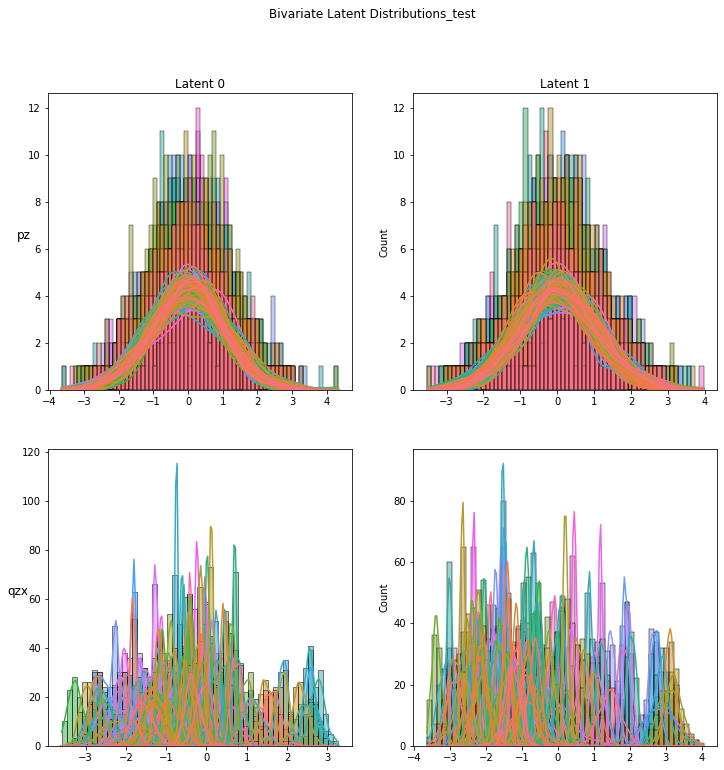

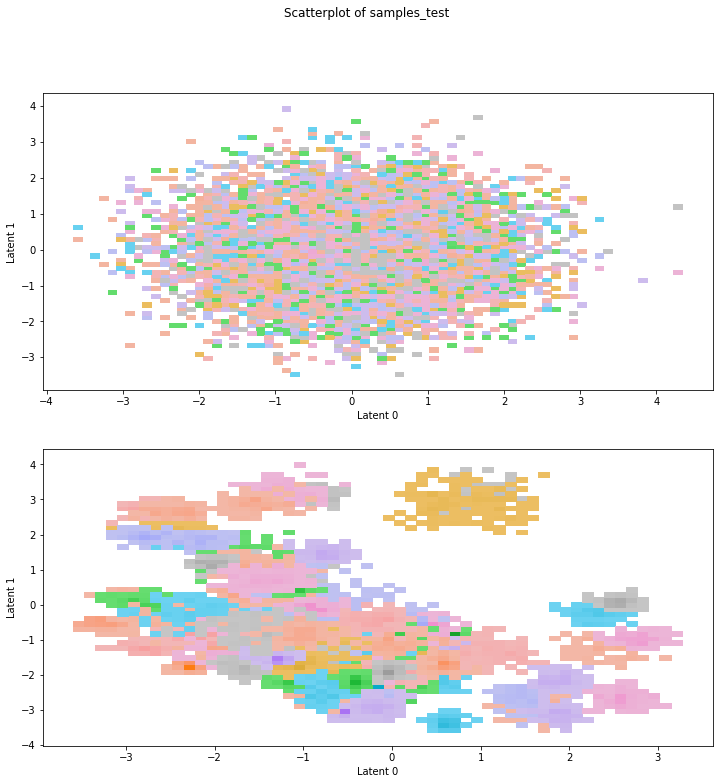

Epoch 2, Loss 21509.2626, kl_loss 672.1667, recon_loss 20837.0960, kl_divergence 491.2196
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


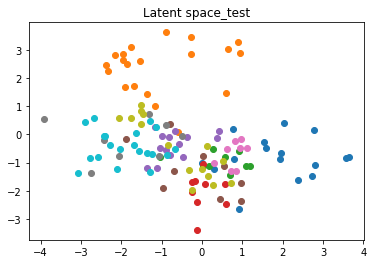

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


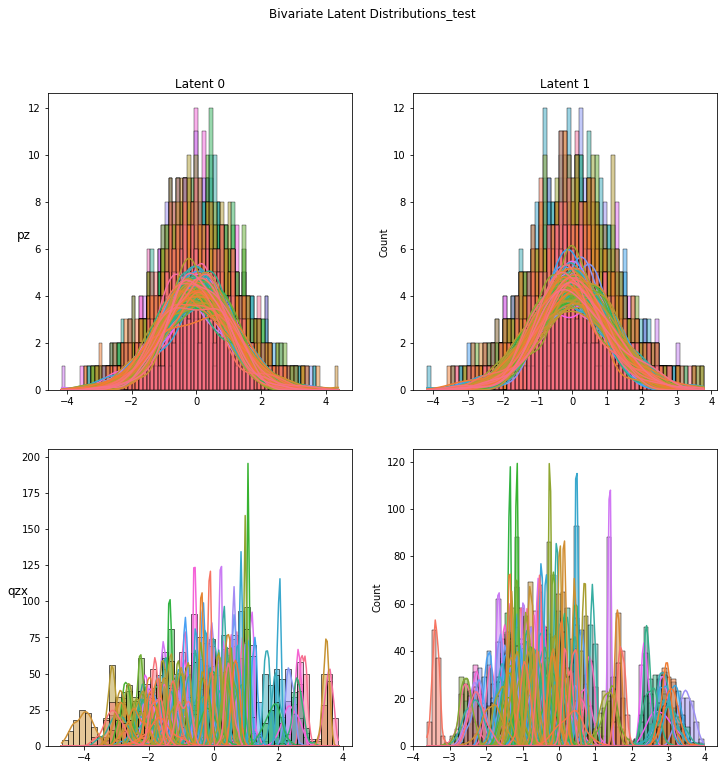

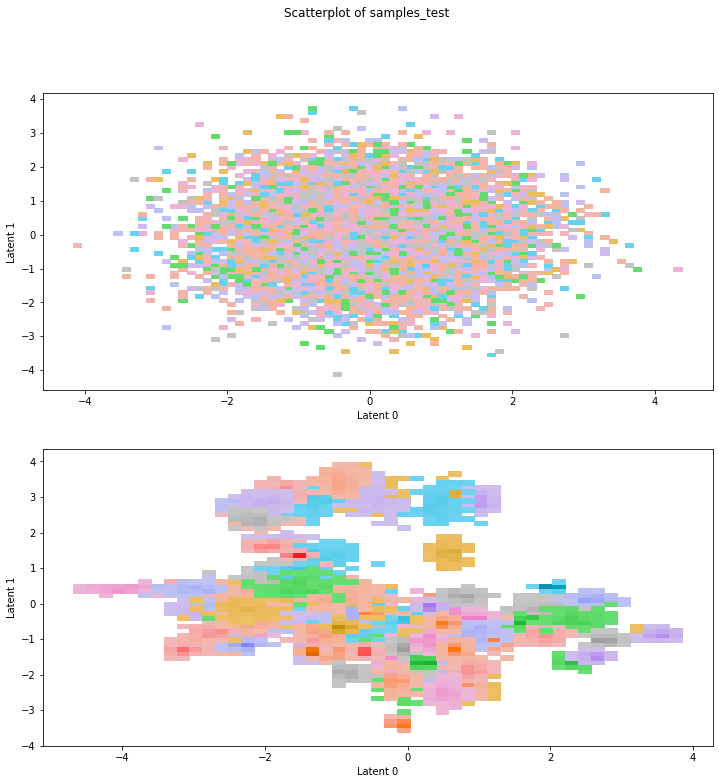

Epoch 3, Loss 20971.8730, kl_loss 686.6608, recon_loss 20285.2121, kl_divergence 470.0660
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


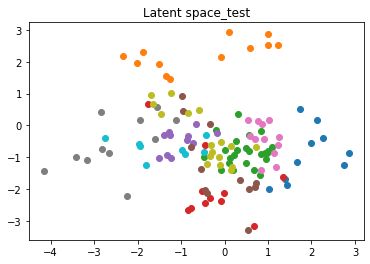

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


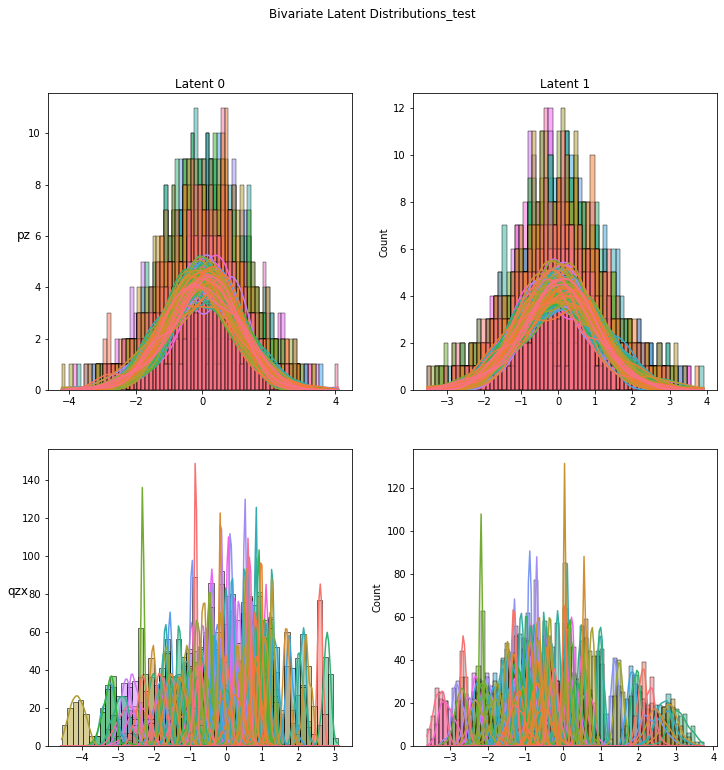

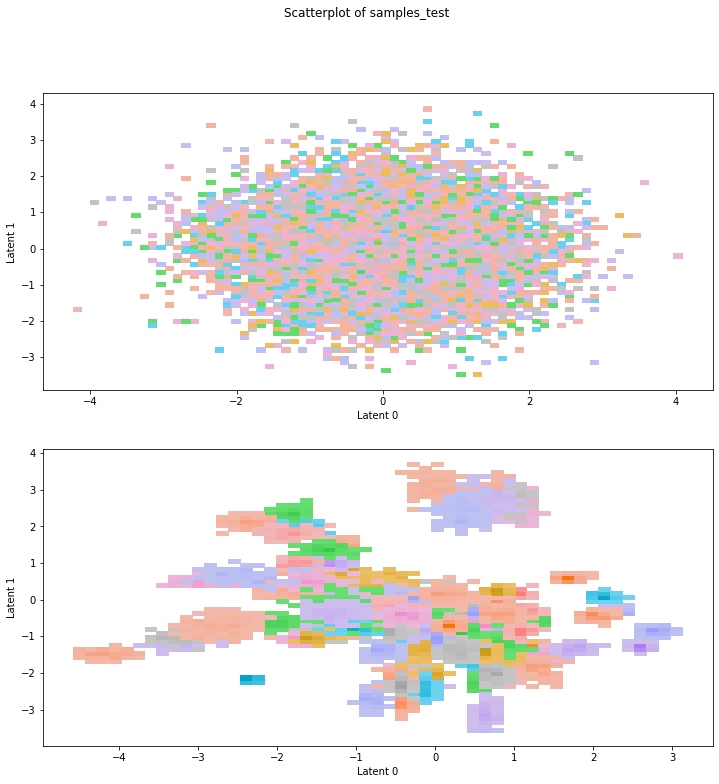

Epoch 4, Loss 20651.3581, kl_loss 696.2990, recon_loss 19955.0591, kl_divergence 459.3056
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


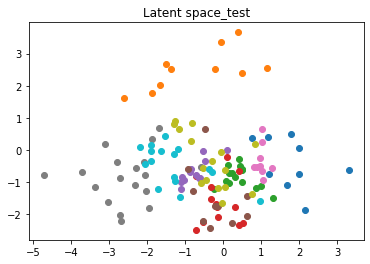

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


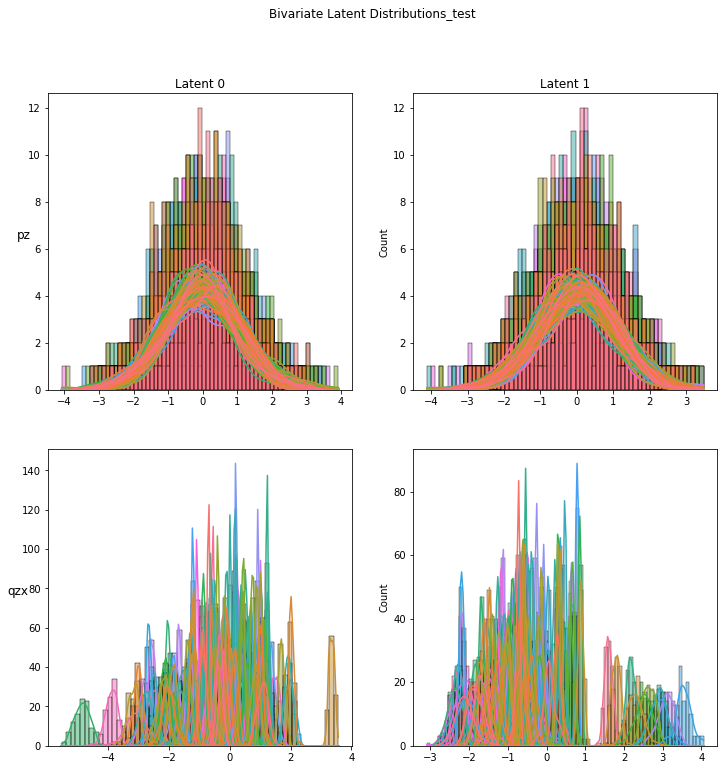

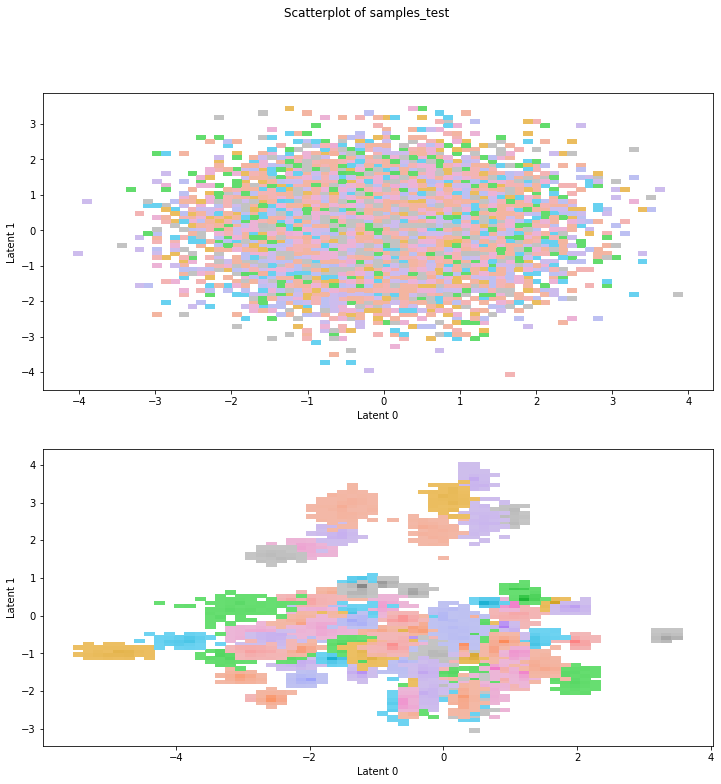

Epoch 5, Loss 20415.5679, kl_loss 704.8515, recon_loss 19710.7165, kl_divergence 452.7028
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


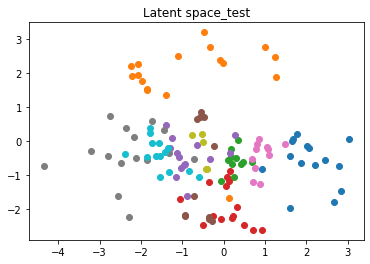

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


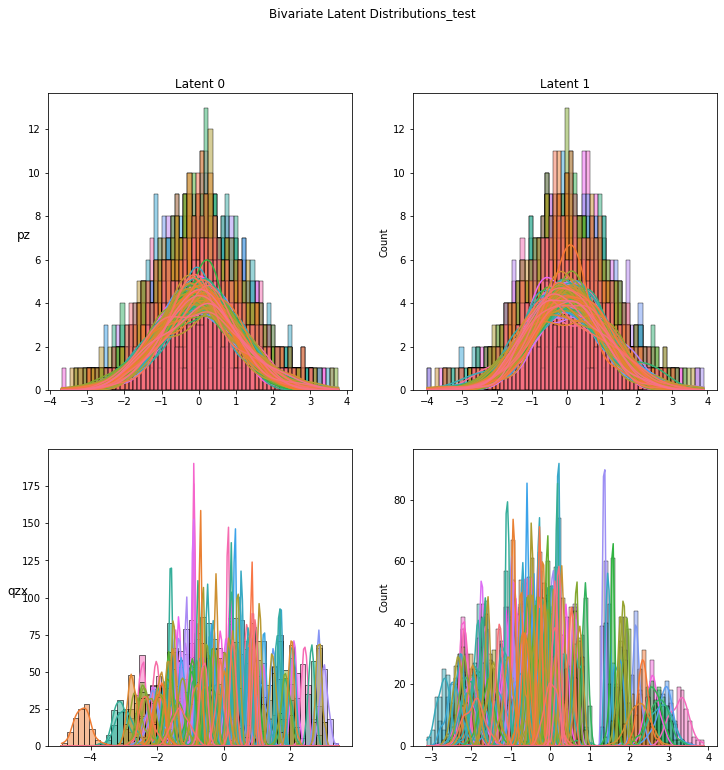

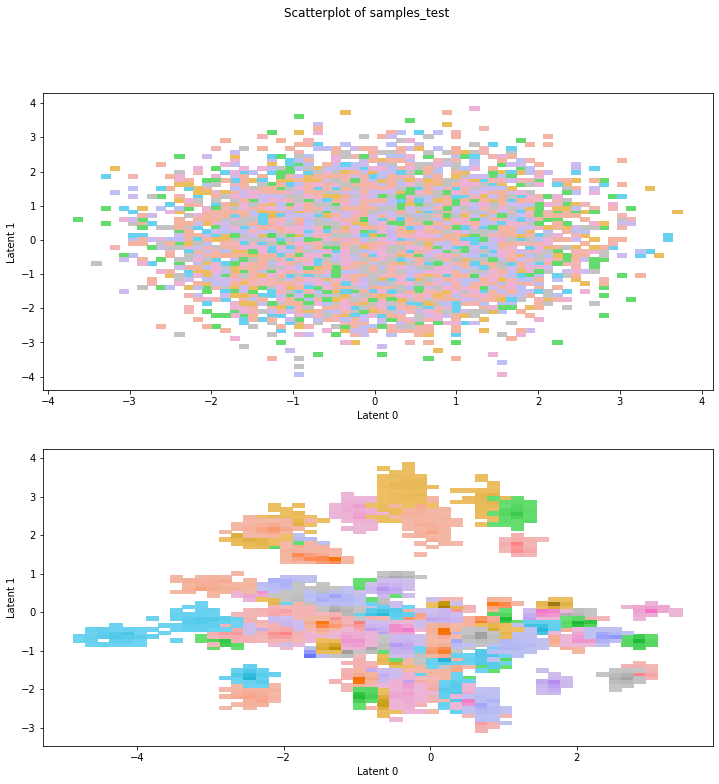

Epoch 6, Loss 20239.9587, kl_loss 713.9371, recon_loss 19526.0216, kl_divergence 449.2407
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


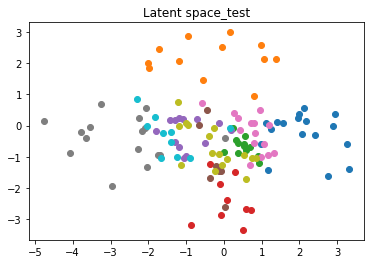

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


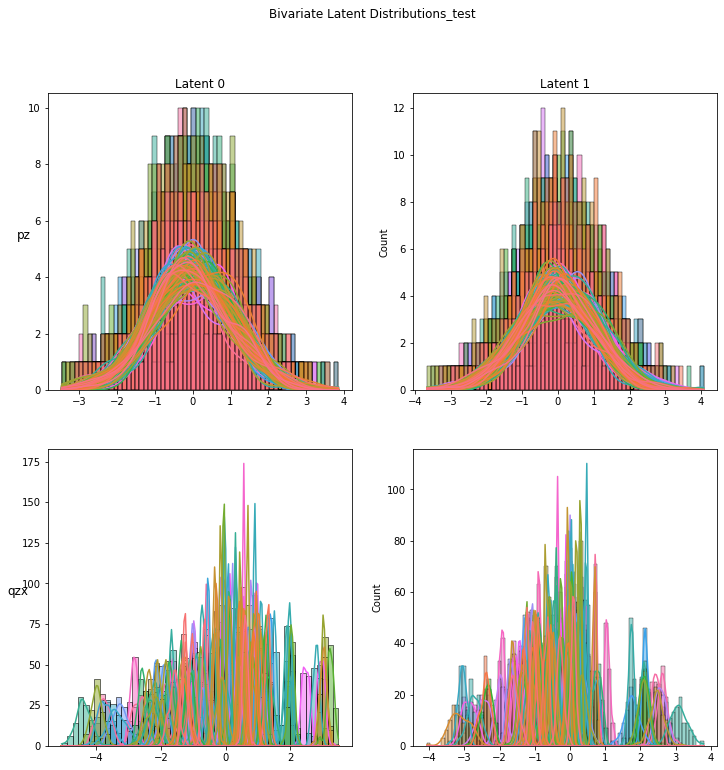

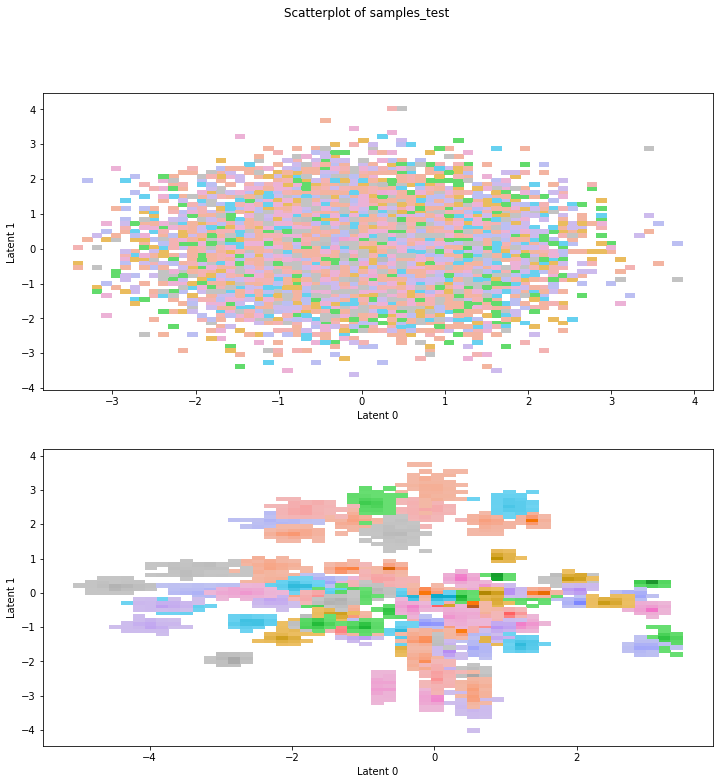

Epoch 11, Loss 19695.2986, kl_loss 745.8773, recon_loss 18949.4213, kl_divergence 439.4040
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


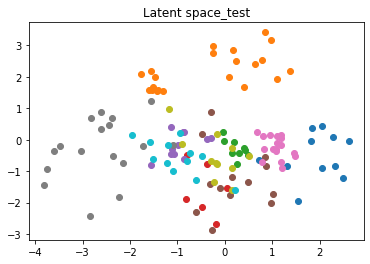

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


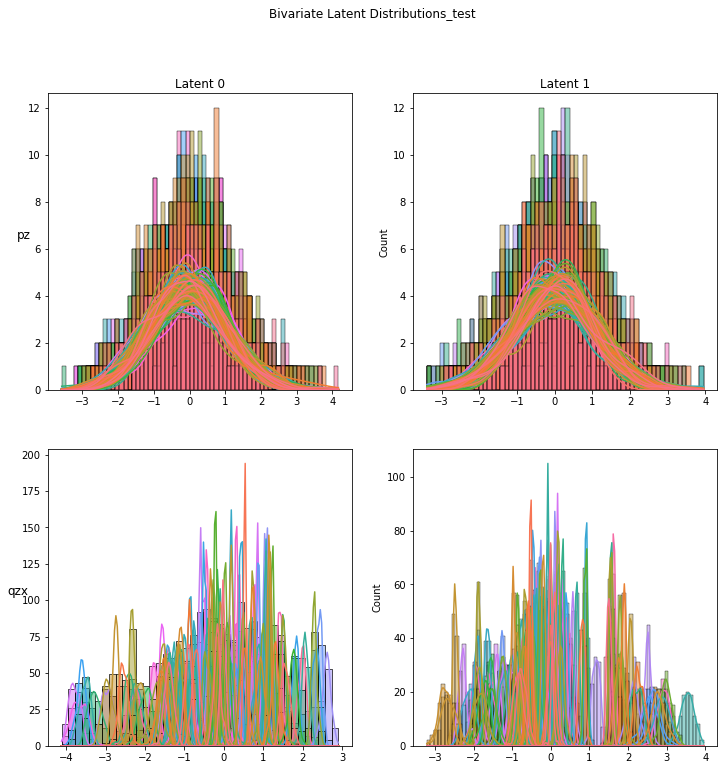

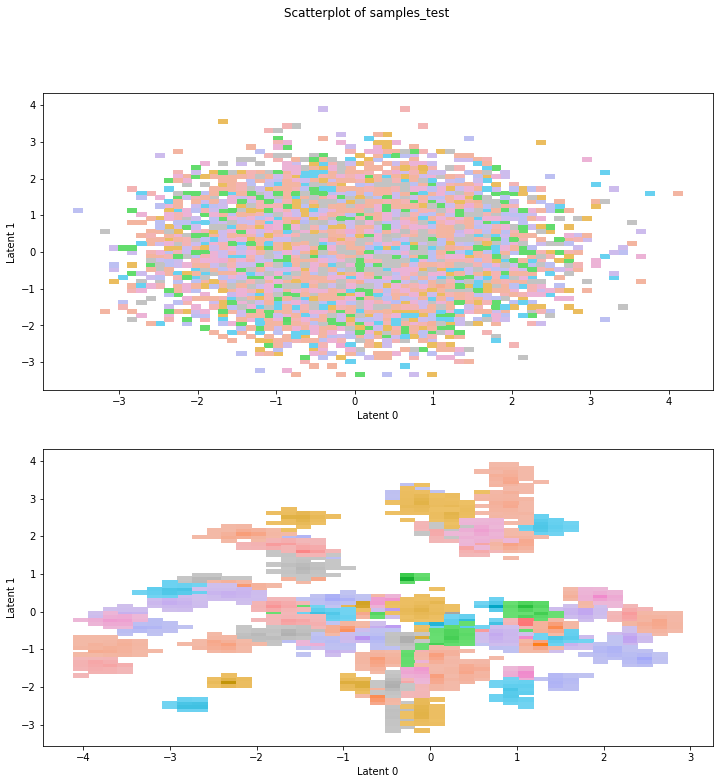

Epoch 16, Loss 19406.1731, kl_loss 763.7973, recon_loss 18642.3757, kl_divergence 433.7580
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


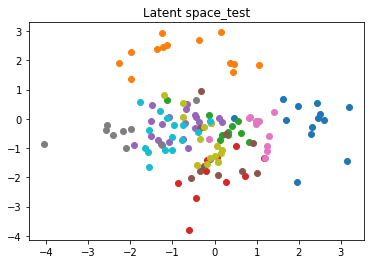

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


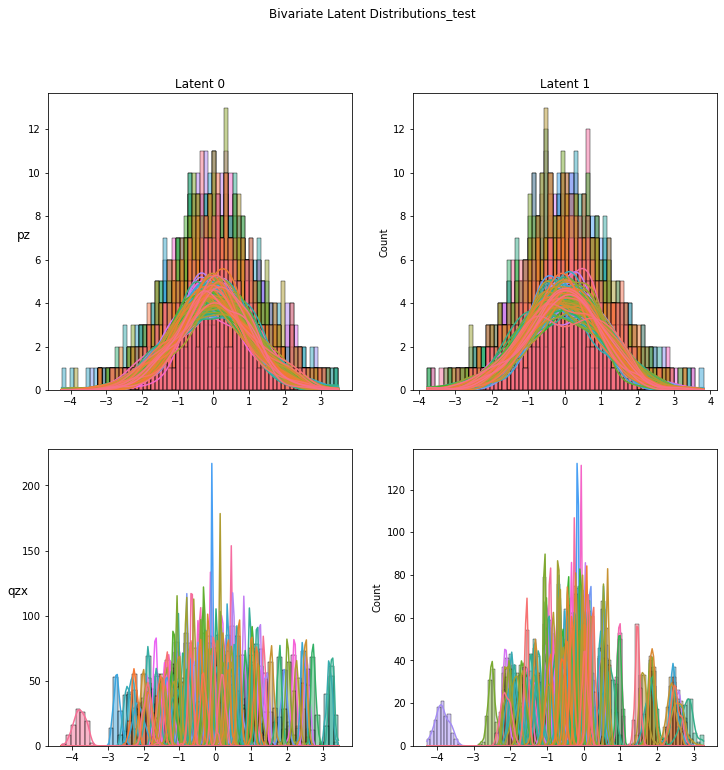

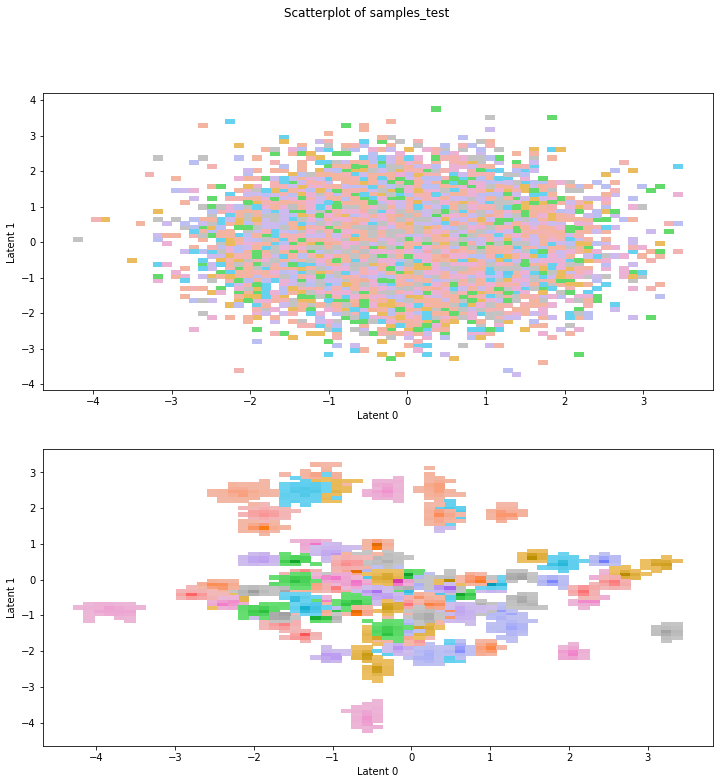

Epoch 21, Loss 19211.6567, kl_loss 777.7488, recon_loss 18433.9080, kl_divergence 431.2480
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


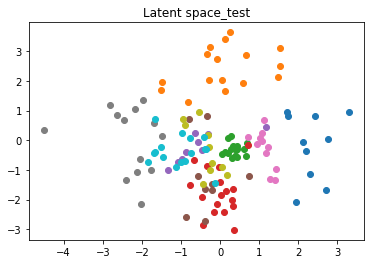

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


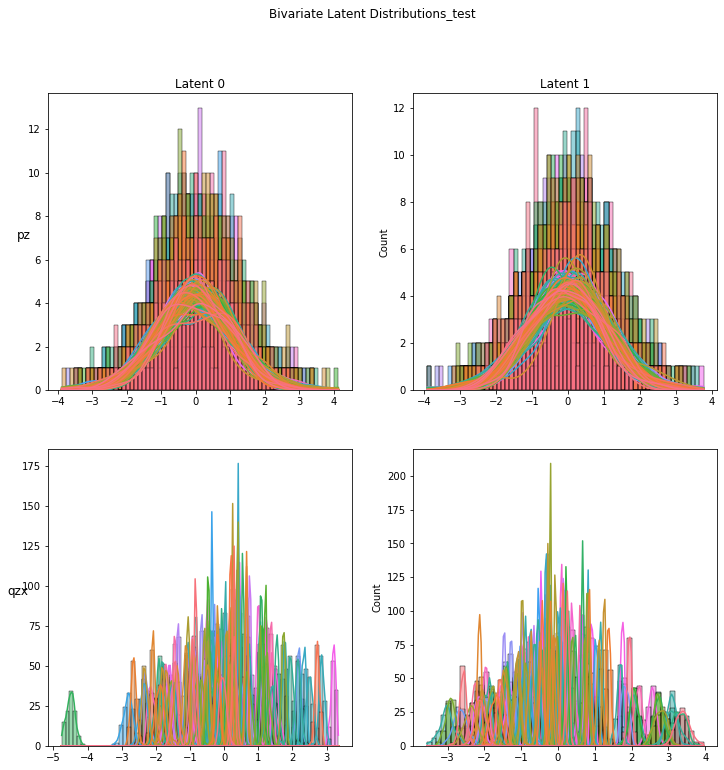

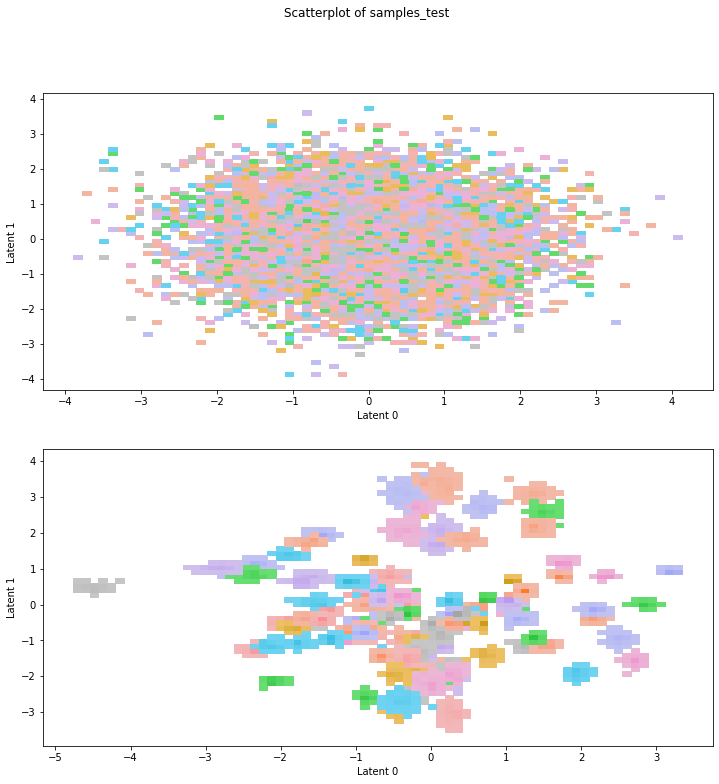

Epoch 26, Loss 19069.2299, kl_loss 788.0586, recon_loss 18281.1712, kl_divergence 429.8770
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


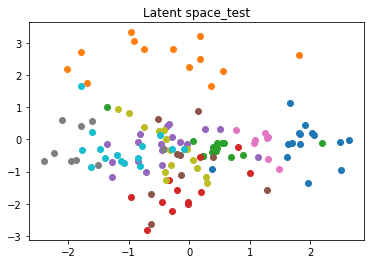

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


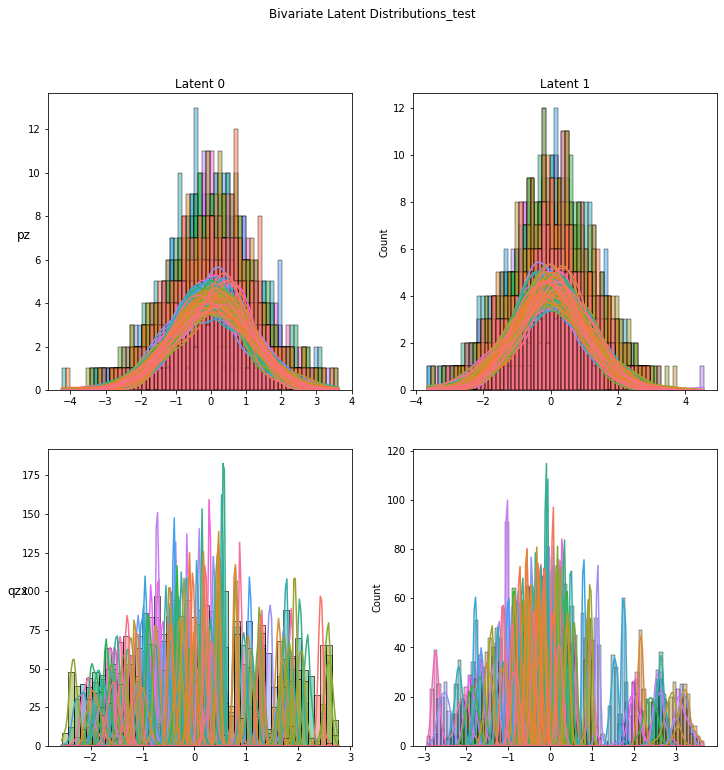

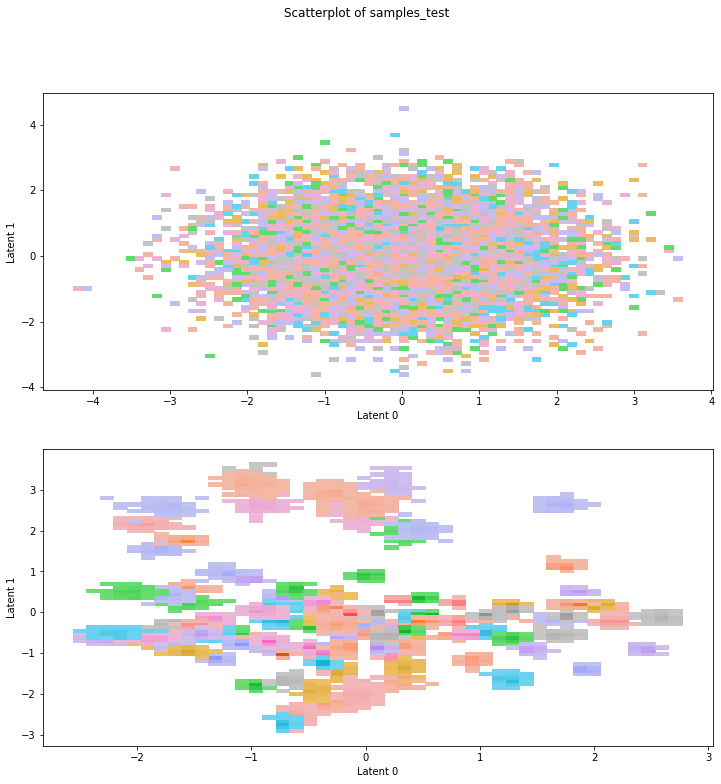

Epoch 31, Loss 18950.5296, kl_loss 796.8960, recon_loss 18153.6337, kl_divergence 428.3900
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


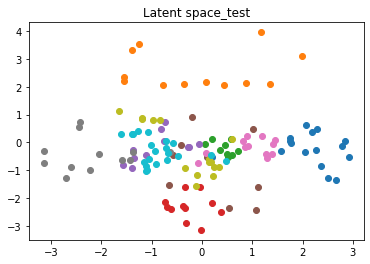

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


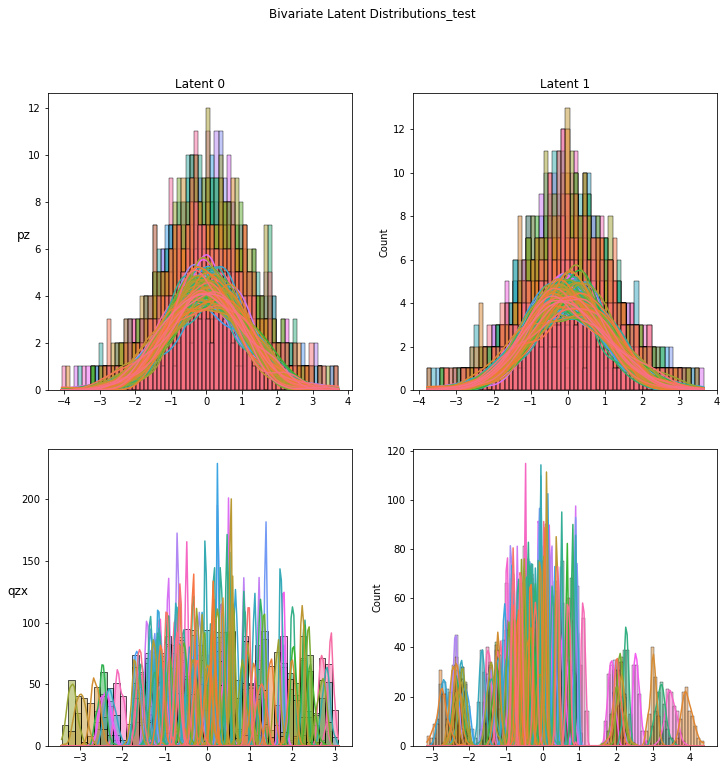

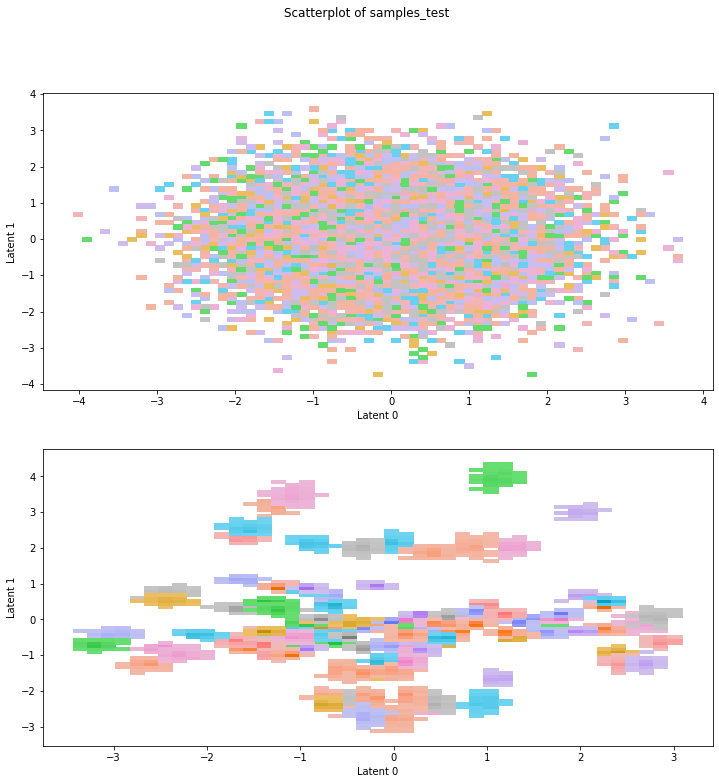

Epoch 36, Loss 18847.2089, kl_loss 803.6994, recon_loss 18043.5094, kl_divergence 429.0268
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


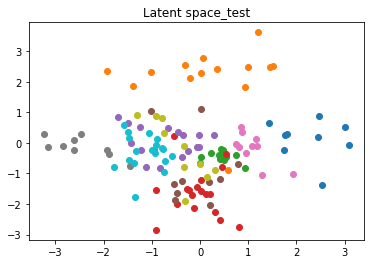

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


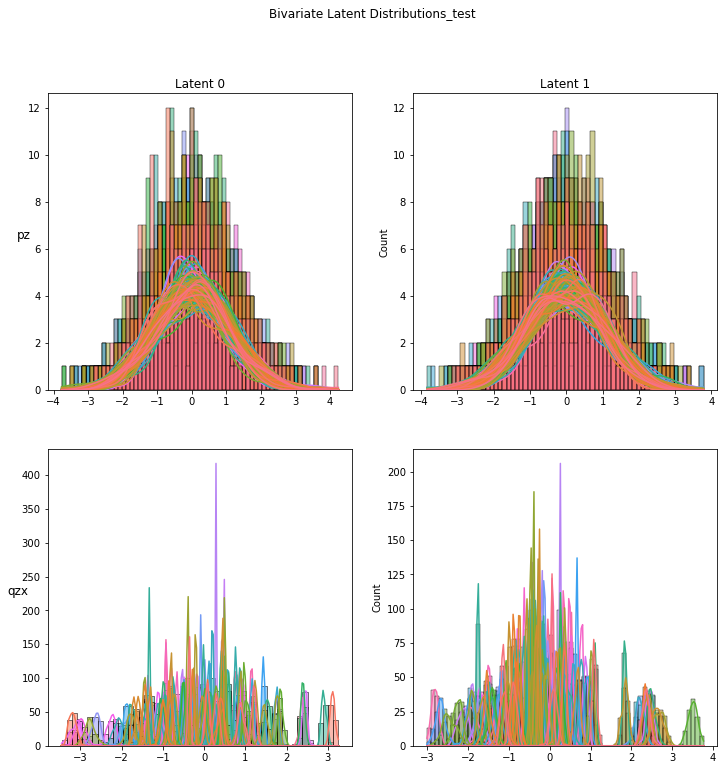

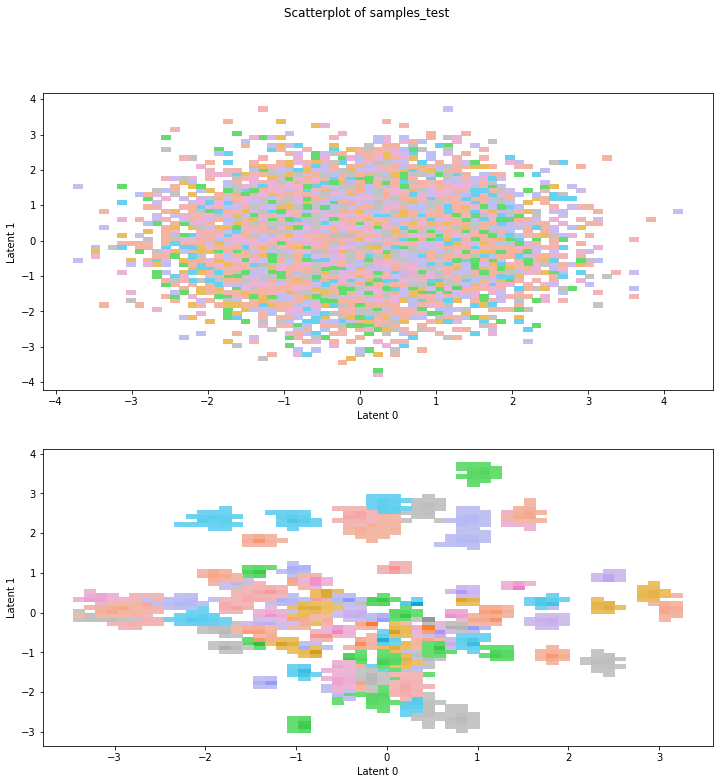

Epoch 41, Loss 18755.5544, kl_loss 806.9019, recon_loss 17948.6526, kl_divergence 428.2860
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


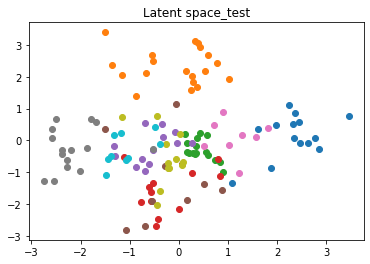

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


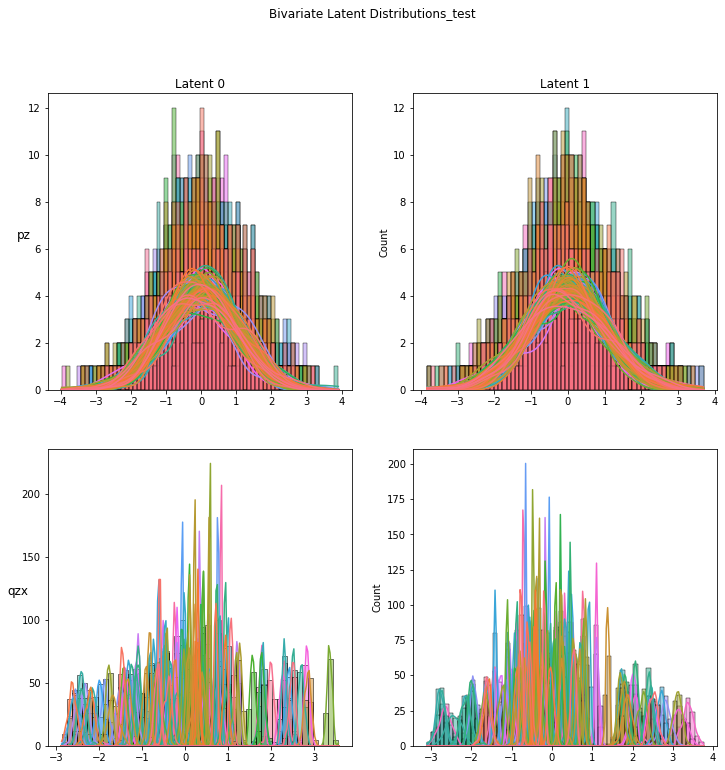

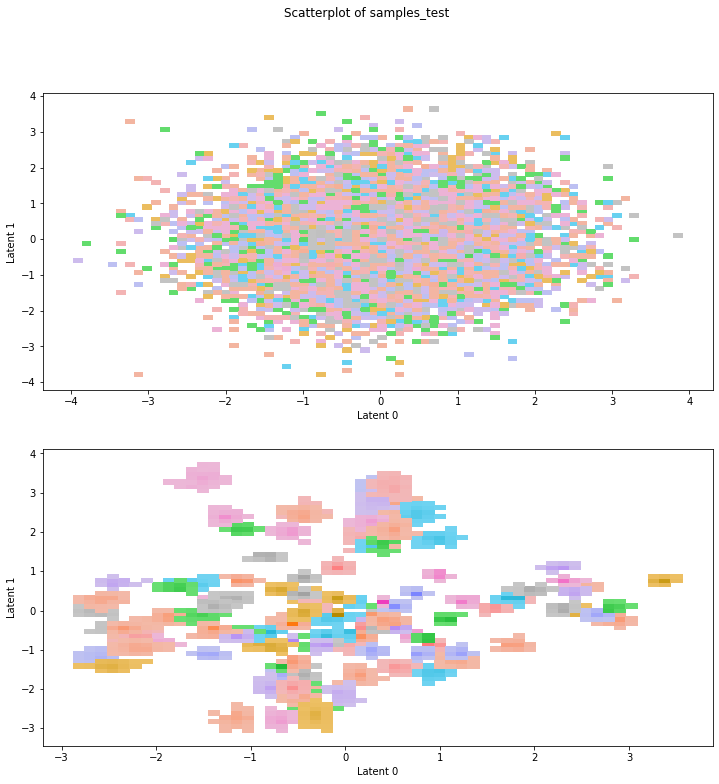

Epoch 46, Loss 18685.7947, kl_loss 813.6818, recon_loss 17872.1129, kl_divergence 426.9016
labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


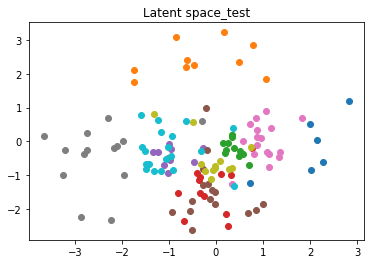

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (100, 128, 2), qzx (100, 128, 2)


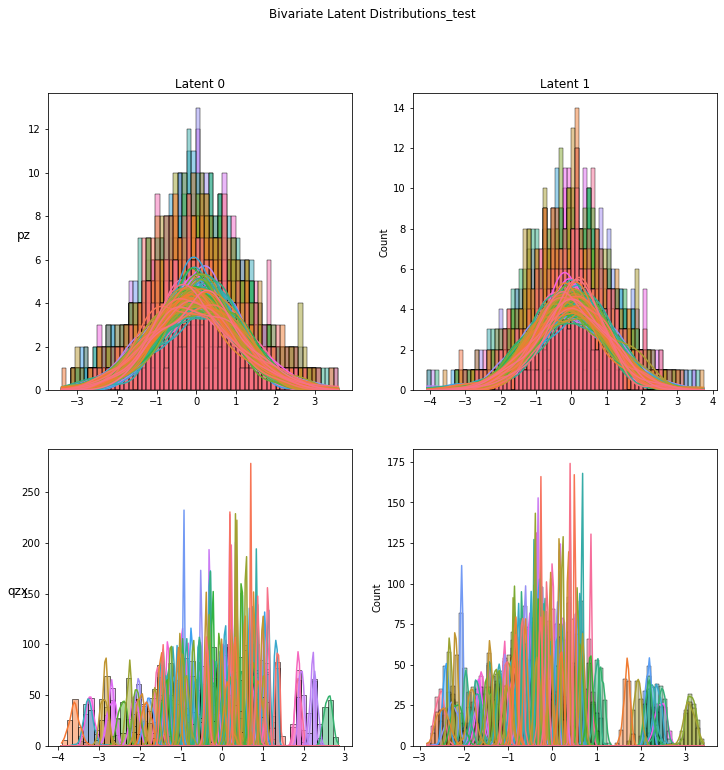

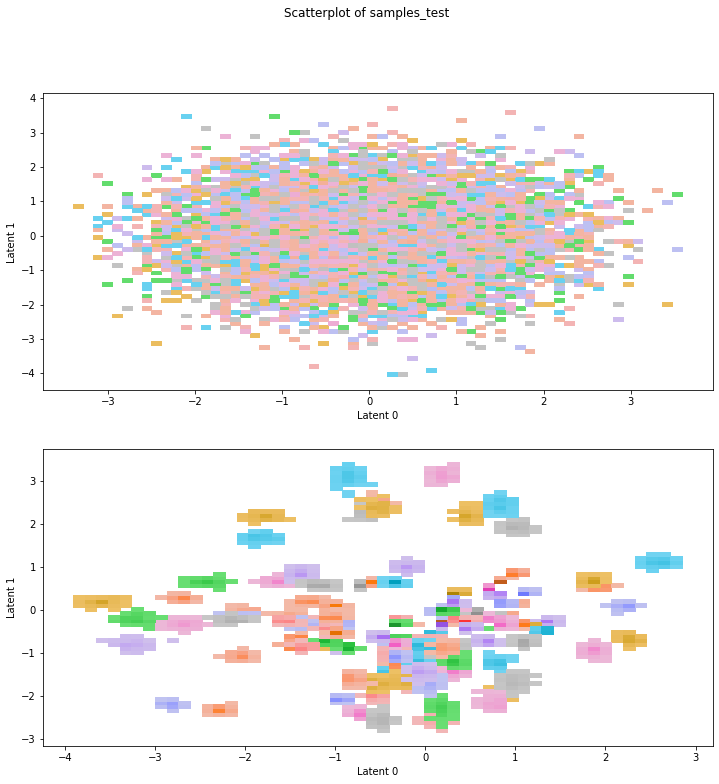

dump results dict to MLP_VAE_dist_l2_wkl_1_wr_1.pkl
CPU times: user 15min 46s, sys: 3.35 s, total: 15min 50s
Wall time: 13min 42s


MLP_VAE(
  (encoder): MLP_V_Encoder(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
  )
  (decoder): MLP_V_Decoder(
    (model): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (enc_to_mean): Linear(in_features=400, out_features=2, bias=True)
  (enc_to_logvar): Linear(in_features=400, out_features=2, bias=True)
)

In [11]:
%%time
if pretrain:
    # load the pretrained model
    model = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    results_dict = pickle.load(open(logDir + dict_name, 'rb'))
    
else:
    # train and save the model
    for (w_kl, w_r) in [[1, 1]]: # [[10, 0], [10, 1]] # w_kl must be greater than 0, otherwise kl_divergence easy to get nan
        model_name = "MLP_VAE_dist_l2_wkl_{}_wr_{}".format(w_kl, w_r)
        model_path = logDir + model_name + ".pt"
        dict_name = model_name + '.pkl'
        model = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim).to(device)
        model, results_dict = train(model, device, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, use_scheduler=False, w_kl=w_kl, w_r=w_r)
        torch.save(model.state_dict(), model_path)
        pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
        print("dump results dict to {}".format(dict_name))
    
model.eval()

## Visualization of the training process and results

### plot the learning curve

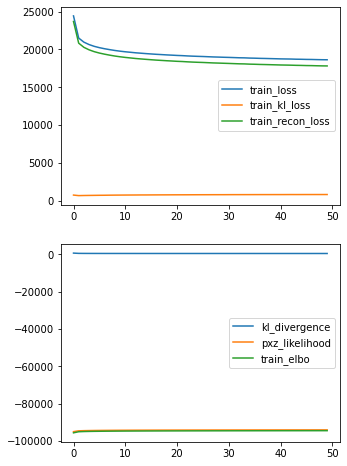

In [12]:
epoch_train_loss = results_dict["train_loss"]
epoch_train_kl_loss = results_dict["train_kl_loss"]
epoch_train_recon_loss = results_dict["train_recon_loss"]

epoch_train_kl_divergence = results_dict["train_kl_divergence"]
epoch_train_pxz_likelihood = results_dict["train_pxz_likelihood"]
epoch_train_elbo = results_dict["train_elbo"]

fig, axes = plt.subplots(2,1, figsize=(5,8))
assert len(epoch_train_loss)==num_epochs, "check num_epochs"
axes[0].plot(np.arange(num_epochs), epoch_train_loss, label="train_loss")
axes[0].plot(np.arange(num_epochs), epoch_train_kl_loss, label="train_kl_loss")
axes[0].plot(np.arange(num_epochs), epoch_train_recon_loss, label="train_recon_loss")
axes[0].legend()
axes[1].plot(np.arange(num_epochs), epoch_train_kl_divergence, label="kl_divergence")
axes[1].plot(np.arange(num_epochs), epoch_train_pxz_likelihood, label="pxz_likelihood")
axes[1].plot(np.arange(num_epochs), epoch_train_elbo, label="train_elbo")
axes[1].legend()

plt.show()

### plot the evolution of reconstruction through epochs

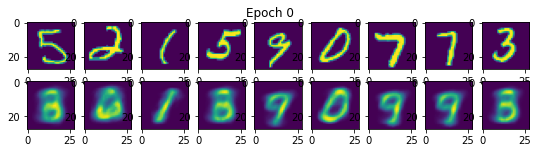

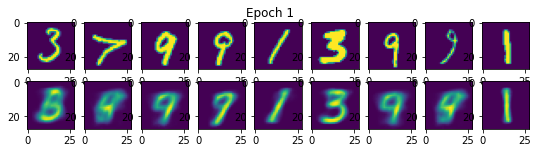

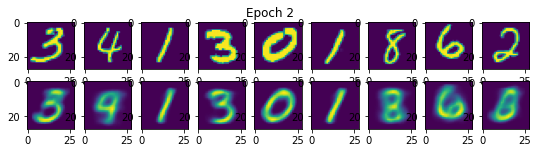

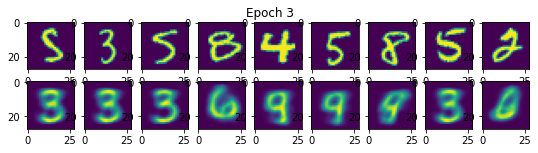

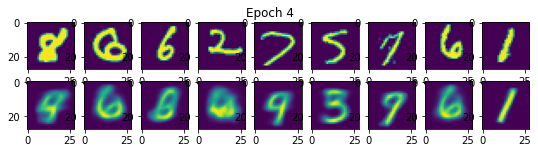

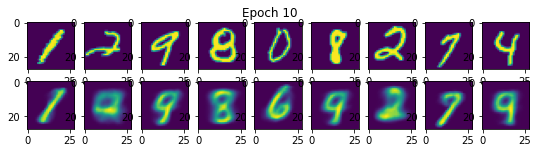

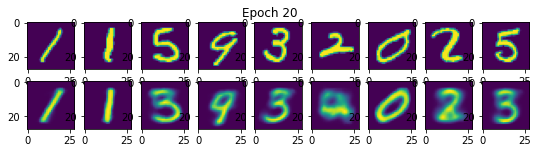

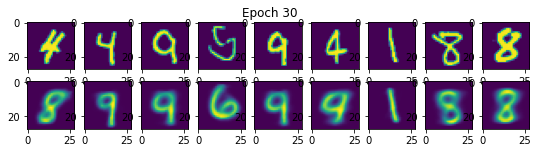

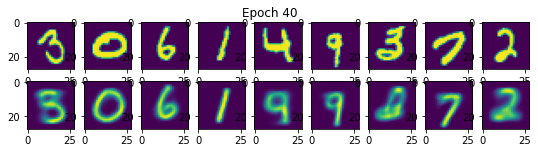

In [13]:
num_cols = 9
selected_epochs = np.concatenate((np.arange(5),np.arange(10,num_epochs,10)))
for epoch in selected_epochs:
    figure = plt.figure(figsize=(num_cols,2))
    figure.suptitle("Epoch {}".format(epoch))
    imgs = results_dict["sample_img"][epoch]
    reconstructions = results_dict["sample_reconstruction"][epoch]
    for i, item in enumerate(imgs):
        # plot only first few images
        if i>=num_cols: break
        plt.subplot(2,num_cols, i+1)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructions):
        if i>=num_cols: break
        plt.subplot(2, num_cols, num_cols+i+1)
        plt.imshow(item[0])

### plot the latent space
The hover part takes reference from [this post](https://github.com/gr-b/autoencoder-latent-space-visualization)

In [14]:
model.eval()
sample_train_imgs, sample_train_labels = next(iter(train_loader))
print(sample_train_imgs.shape, sample_train_labels.shape)
sample_test_imgs, sample_test_labels = next(iter(test_loader))
print(sample_test_imgs.shape, sample_test_labels.shape)
sample_train_imgs, sample_test_imgs = torch.tensor(sample_train_imgs).float().to(device), torch.tensor(sample_test_imgs).float().to(device)

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])


labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


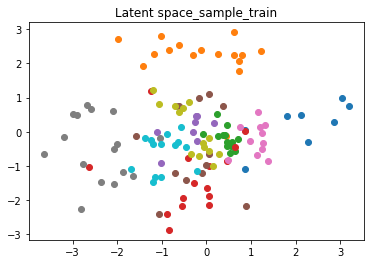

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (1000, 128, 2), qzx (1000, 128, 2)


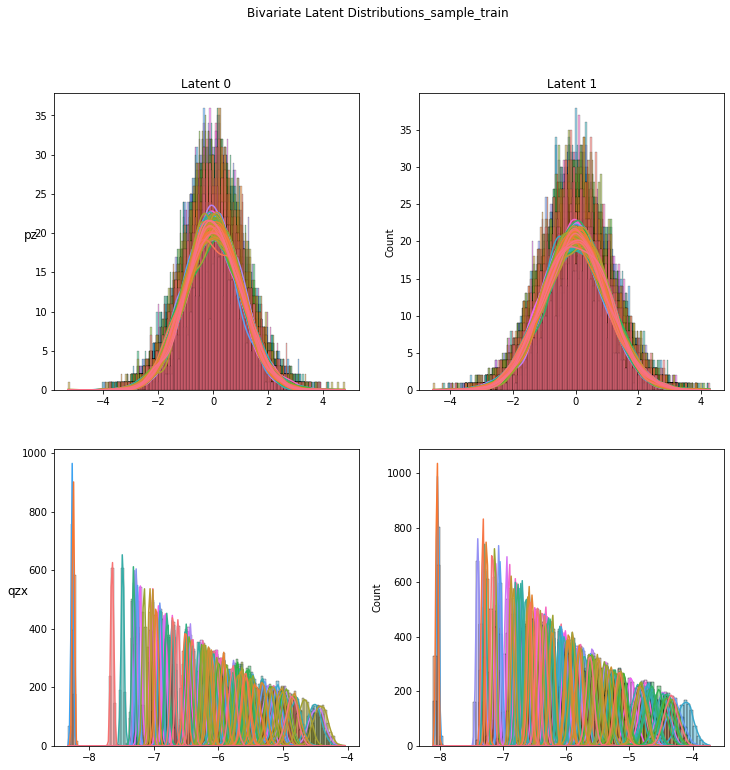

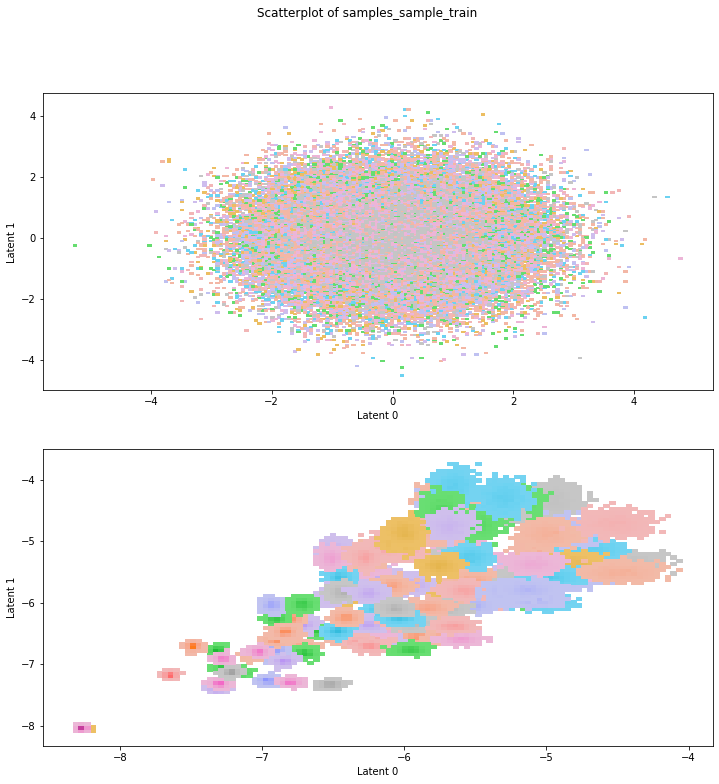

labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


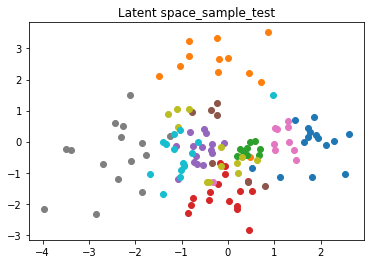

Plot bivariate latent distributions
pz batch_shape torch.Size([128, 2]), event_shape torch.Size([])
qzx batch_shape torch.Size([128, 2]), event_shape torch.Size([])
check p, q shape, pz (1000, 128, 2), qzx (1000, 128, 2)


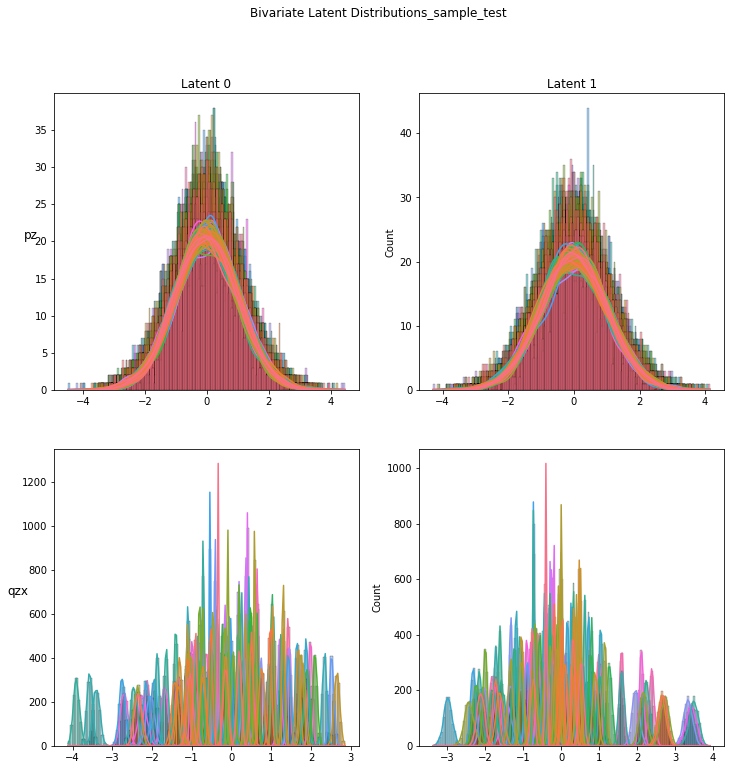

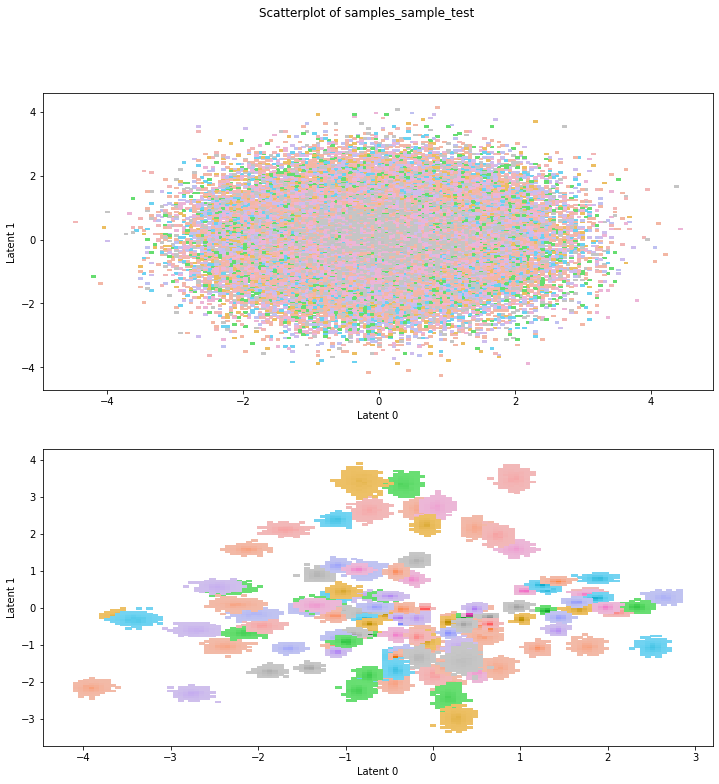

In [15]:
sample_train_latents, sample_train_reconstructions, sample_train_latent_logvar, sample_train_latent_logvar = model(sample_train_imgs)
sample_test_latents, sample_test_reconstructions, sample_test_latent_mean, sample_test_latent_logvar = model(sample_test_imgs)
plot_latent(sample_train_labels, sample_train_latents, dtype="tensor", suptitle_app="_sample_train")
plot_p_q(sample_train_latent_logvar, sample_train_latent_logvar, N_samples=1000,suptitle_app="_sample_train")
plot_latent(sample_test_labels, sample_test_latents, dtype="tensor", suptitle_app="_sample_test")
plot_p_q(sample_test_latent_mean, sample_test_latent_logvar, N_samples=1000, suptitle_app="_sample_test")

labels <class 'numpy.ndarray'> (10000,)
latents <class 'numpy.ndarray'> (10000, 2)


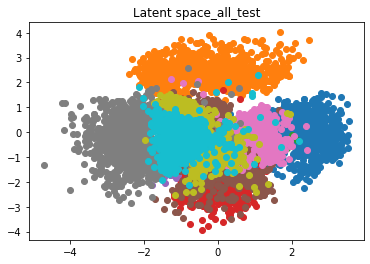

In [16]:
# plot the whole test latent space
all_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)
all_test_imgs, all_test_labels = next(iter(all_test_loader))
all_test_imgs = torch.tensor(all_test_imgs).float().to(device)
all_test_latents, all_test_reconstructions, all_test_latent_means, all_test_latent_logvars = model(all_test_imgs)
plot_latent(all_test_labels, all_test_latents, dtype="tensor", suptitle_app="_all_test")
# plot_p_q(all_test_latent_means, all_test_latent_logvars, N_samples=1000, suptitle_app="_sample_test") # takes forever

In [17]:
all_test_latents = all_test_latents.cpu().detach().numpy()
all_test_labels = all_test_labels.cpu().detach().numpy()

In [24]:
import PyQt5
%matplotlib qt 
# interactive hovering

fig, ax = plt.subplots(1, 2)
plt.tight_layout()
for y in np.unique(all_test_labels):
    i = np.where(all_test_labels == y)
    ax[0].scatter(all_test_latents[i,0], all_test_latents[i,1], label=y, cmap="tab10")
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
    
def onclick(event):
    global flag
    if event.xdata is None or event.ydata is None:
        return
    ix, iy = int(event.xdata), int(event.ydata)
    
    latent_vector = np.array([[ix, iy]])
    latent_vector = torch.from_numpy(latent_vector).float().to(device)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] # [1,1,28,28] => [28,28]
    ax[1].imshow(decoded_img)
    plt.draw()

# button_press_event
# motion_notify_event
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)

plt.show() 

### Interpolation between any two images

In [19]:
%matplotlib inline

In [20]:
def interpolate(index1, index2):
    x1 = results_dict["sample_img"][-1][index1]
    x2 = results_dict["sample_img"][-1][index2]
    x1, x2 = torch.from_numpy(x1).float().to(device), torch.from_numpy(x2).float().to(device)
    x = torch.stack([x1, x2])
    latent_mean, latent_logvar = model.encode(x)
    embedding = model.sample_latent_embedding(latent_mean, latent_logvar)
    e1 = embedding[0]
    e2 = embedding[1]
    
    embedding_values = []
    for i in range(10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)
    recon_from_embeddings = model.decoder(embedding_values) # shape [10, 1, 28, 28]
    
    plt.figure(figsize=(10,2))
    for i, recon in enumerate(recon_from_embeddings.cpu().detach().numpy()):
        plt.subplot(2, 10, i+1)
        plt.imshow(recon[0])
    # plot two original images
    plt.subplot(2, 10, 11)
    plt.imshow(x2.cpu().detach().numpy()[0])
    plt.subplot(2, 10, 20)
    plt.imshow(x1.cpu().detach().numpy()[0])

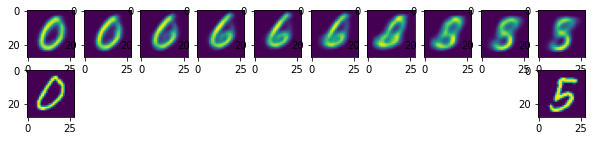

In [21]:
interpolate(3,5)

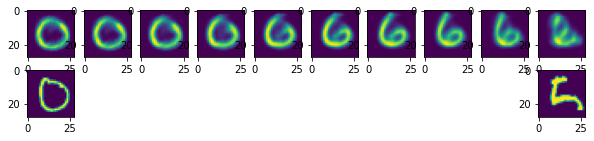

In [22]:
interpolate(2,7)

### Interactive scroll bar for latent space

see VAE_MNIST_Interactive_ScrollBar